# Modelling

In [130]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [1]:
import numpy as np
from scipy.sparse import csr_array, lil_array
import matplotlib.pyplot as plt
import pandas as pd
import math
import pickle
import time
import datetime
import random
from pprint import pprint
from lightgbm import LGBMRanker
from sklearn.model_selection import train_test_split

from SVD import Metrics, RatingSVD, LogisticSVD
from RecData import RecData

## Data Preprocessing

In [2]:
# recs = pd.read_csv('data/recommendations.csv')
# recs = pd.read_csv('data/pruned.csv')
# recs = pd.read_csv('data/2plus.csv')
recs = pd.read_csv('data/full_pruned.csv')

USED_COLS = ['app_id', 'is_recommended', 'user_id']
recs = recs[USED_COLS]

item_data = pd.read_csv('data/games.csv')
titles = item_data[['app_id', 'title']]

print("Shape:", recs.shape)
recs.sort_values(by=['user_id', 'app_id']).head()

Shape: (1482464, 3)


,app_id,is_recommended,user_id
420790,12210,True,240
675882,22380,True,240
246231,239140,True,240
539676,251570,True,240
521289,270880,True,240


In [3]:
# random.seed(42)
# np.random.seed(42)

# rec_data = RecData()
# rec_data.create_from_dataframe(recs)
# rec_data.set_titles(titles)

# # del recs

# start_time = time.time()
# print("Creating splits...")
# train_data, test = rec_data.train_test_split(test_size=0.2)
# print("First split done.")
# train_data, val = train_data.train_test_split(test_size=0.2)
# print("Done creating splits in", time.time() - start_time, "seconds")

In [4]:
random.seed(42)
np.random.seed(42)
rec_data = RecData()
rec_data.create_from_dataframe(recs)
rec_data.set_titles(titles)

# del recs

print("Creating splits...")
train_data, val = rec_data.leave_k_out_split(k=1, create_val=False)
print("Done creating splits.")

Creating utility matrix...
Done utility matrix.
Creating splits...
Done user 1 / 63175
Done user 10001 / 63175
Done user 20001 / 63175
Done user 30001 / 63175
Done user 40001 / 63175
Done user 50001 / 63175
Done user 60001 / 63175
Done creating splits.


In [5]:
del rec_data
del item_data
del titles

## Ranker

This was used as a postprocessing step after using item-knn for candidate generation. Was not able to get good results.

In [6]:
# train = train_data.generate_dataframe()
# X_train = train[['app_id', 'user_id']]
# y_train = train['is_recommended'].to_numpy()

# X_train = X_train.sort_values(by='user_id')
# counts = X_train['user_id'].value_counts(sort=False)
# X_train = X_train[['app_id']]

In [7]:
# ranker = LGBMRanker(n_estimators=300, random_state=42, objective='lambdarank')
# ranker = ranker.fit(X_train, y_train, group = counts.values, categorical_feature=['app_id'],
#                     eval_set=[(X_train, y_train)], eval_group=[counts.values], 
#                     eval_at=20)

## Training SVD

In [ ]:
# for pruned, epoch: 80, lr:0.01, reg:0.02, k=100
# for 2plus, epoch: 80, lr:0.01, reg:0.02, k=100

random.seed(42)
np.random.seed(42)

# Fit and predict with svd
svd_predictor = RatingSVD(
    train_data.get_num_users(), train_data.get_num_items(), 2, k=10, 
    learning_rate=0.001, C=0.2)
svd_predictor.fit(train_data.get_matrix(), 100, validation_set=val, early_stop=False)
# svd_predictor = LogisticSVD(
#     train_data.get_num_users(), train_data.get_num_items(), 2, k=100, 
#     learning_rate=0.01, C=0.04)
# svd_predictor.fit(train_data.get_matrix(), 40, validation_set=val, early_stop=False)

# Plot error
errors = svd_predictor.get_train_errors()
val_errors = svd_predictor.get_val_errors()
plt.plot(range(len(errors)), errors, label='Training loss')
plt.plot(range(len(val_errors)), val_errors, label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Error vs Epoch')
plt.legend()
plt.show()

# Compute rmse
predictions = svd_predictor.predict_pairs([(user, item) for user, item, _ in val])
predictions = [prediction + (val[i][2],) for i, prediction in enumerate(predictions)]
metrics = Metrics()
rmse = metrics.rmse(predictions)
print("Validation rmse", rmse)

Epoch 0/Training loss: 0.37502660502019985/Validation loss: 0.3737263249625181/Time: 6.17 seconds
Epoch 1/Training loss: 0.371285541815378/Validation loss: 0.37074977533228437/Time: 6.26 seconds
Epoch 2/Training loss: 0.3687323211853964/Validation loss: 0.36884130254700154/Time: 6.29 seconds
Epoch 3/Training loss: 0.3665419160447822/Validation loss: 0.36721442551731504/Time: 6.19 seconds
Epoch 4/Training loss: 0.3646750854003191/Validation loss: 0.36581298409220914/Time: 6.22 seconds
Epoch 5/Training loss: 0.36294131413045105/Validation loss: 0.3645347609667225/Time: 6.14 seconds
Epoch 6/Training loss: 0.36138215633801/Validation loss: 0.3633715820160277/Time: 6.28 seconds
Epoch 7/Training loss: 0.35992540691668823/Validation loss: 0.3622900462467021/Time: 6.29 seconds
Epoch 8/Training loss: 0.35852807558885774/Validation loss: 0.36125042460282775/Time: 6.55 seconds
Epoch 9/Training loss: 0.35727650507121683/Validation loss: 0.3602729578491691/Time: 6.23 seconds
Epoch 10/Training loss:

We can now continue to train if we believe the model is still underfitting.

In [60]:
svd_predictor.continue_fit(5, early_stop=False)

Epoch 0/Training loss: 0.32828594311114895/Validation loss: 0.3396715959337265/Time: 6.66 seconds
Epoch 1/Training loss: 0.328244723120694/Validation loss: 0.33969223099285445/Time: 6.66 seconds
Epoch 2/Training loss: 0.328211382592636/Validation loss: 0.3396554953091627/Time: 6.68 seconds
Epoch 3/Training loss: 0.32817317781434/Validation loss: 0.33967215435384385/Time: 6.61 seconds
Epoch 4/Training loss: 0.32813444207788917/Validation loss: 0.33967858608151985/Time: 6.6 seconds


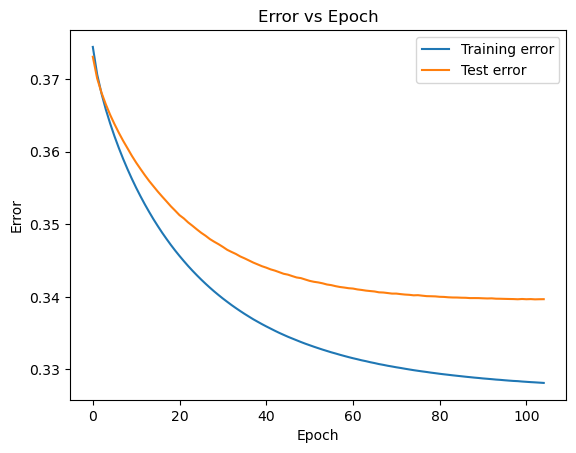

Test rmse 0.33967858608151985


In [62]:
# Plot error
errors = svd_predictor.get_train_errors()
val_errors = svd_predictor.get_val_errors()
plt.plot(range(len(errors)), errors, label='Training error')
plt.plot(range(len(val_errors)), val_errors, label='Test error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Error vs Epoch')
plt.legend()
plt.show()

# Compute rmse
predictions = svd_predictor.predict_pairs([(user, item) for user, item, _ in val])
predictions = [prediction + (val[i][2],) for i, prediction in enumerate(predictions)]
metrics = Metrics()
rmse = metrics.rmse(predictions)
print("Test rmse", rmse)

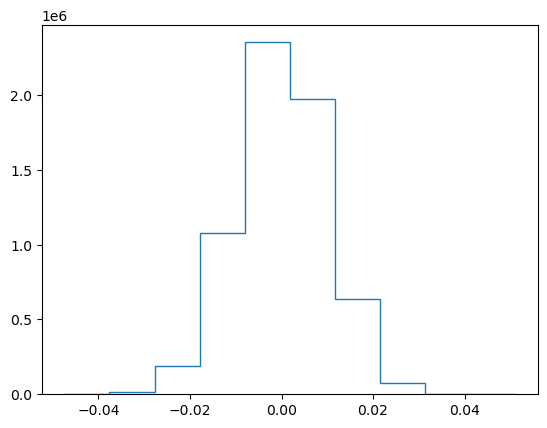

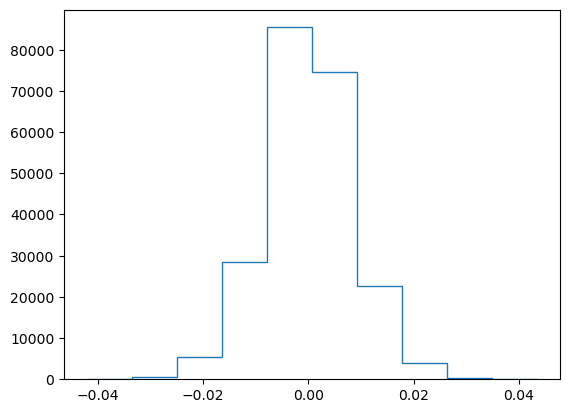

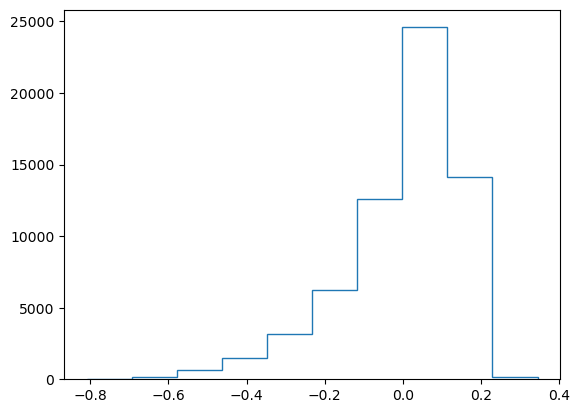

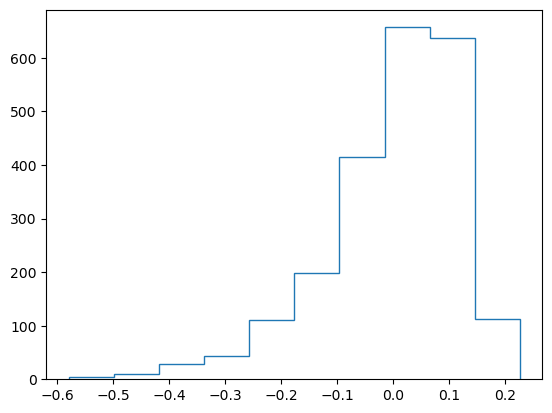

In [13]:
values, edges = np.histogram(svd_predictor._user_features)
plt.stairs(values, edges)
plt.show()

values, edges = np.histogram(svd_predictor._item_features)
plt.stairs(values, edges)
plt.show()

values, edges = np.histogram(svd_predictor._user_biases)
plt.stairs(values, edges)
plt.show()

values, edges = np.histogram(svd_predictor._item_biases)
plt.stairs(values, edges)
plt.show()

In [19]:
svd_predictor._item_biases[1539]

array([0.2266501])

In [18]:
svd_predictor._user_features[5]

array([ 0.00952613,  0.01864404, -0.01346813,  0.00450906, -0.00616643,
       -0.00447825, -0.00522089, -0.00890432,  0.00052135, -0.00841495,
        0.00300656, -0.0001783 , -0.00246038, -0.0086499 , -0.00564713,
        0.00816195,  0.0048527 , -0.00946546,  0.0004621 ,  0.00807172,
       -0.01594918,  0.00550636, -0.00610157,  0.00579452, -0.00686351,
       -0.01740858, -0.01576945,  0.00032434,  0.00182752, -0.00924067,
        0.00556033, -0.01720652, -0.00022305, -0.0114425 , -0.00665847,
        0.00093457, -0.0078923 , -0.00324512,  0.00987312, -0.00552721,
        0.0084424 , -0.01078904,  0.00557768,  0.01216085, -0.02358646,
       -0.00761   ,  0.00506585, -0.00236688,  0.00390922, -0.00609607,
        0.00192263, -0.00172764,  0.01129835,  0.00260308,  0.0034957 ,
       -0.00394494, -0.00374314, -0.00367062,  0.00479199, -0.00336754,
        0.00307423,  0.02006317,  0.00876805, -0.00334132,  0.01140959,
       -0.00391327, -0.019327  , -0.00885831, -0.01750494, -0.00

We compute similarities for item-knn.

In [71]:
svd_predictor.compute_sims()

Computing similarities...
Upto row 1 / 2215
Upto row 201 / 2215
Upto row 401 / 2215
Upto row 601 / 2215
Upto row 801 / 2215
Upto row 1001 / 2215
Upto row 1201 / 2215
Upto row 1401 / 2215
Upto row 1601 / 2215
Upto row 1801 / 2215
Upto row 2001 / 2215
Upto row 2201 / 2215
Done computing similarities in 433.3377513885498 seconds


## Preparing for Production

In [81]:
svd_predictor.prep_for_item_knn()
train_data.prep_for_item_knn()

## Saving the model

In [82]:
# Ensure file exists
model_dir = model_dir = "saved_models/{}-{}-{}-{}-{}-{}_{}".format(
    *(time.localtime()[:6] + (round(rmse, 4), ))).replace(".", "-") + ".pkl" 
file = open(model_dir, 'a')
file.close()

# Save model
print("Saving model...")
with open(model_dir, 'wb') as file:
    pickle.dump([train_data, svd_predictor], file)
print("Done saving model.")

Saving model...
Done saving model.


## Tests

In [2]:
with open('saved_models/2023-7-8-12-15-13_0-37.pkl', 'rb') as file:
    train_data, svd_predictor = pickle.load(file)

### Testing Rerank

In [10]:
# data.search_title('forza')

In [11]:
# filtered = svd_predictor.items_top_n([(286, 1)])
# app_ids = []
# for item_index in filtered:
#     app_ids.append(data.index_to_item_id(item_index))
# df = pd.DataFrame({'app_id': app_ids})
# predictions = ranker.predict(df)
# df['relevance'] = predictions
# df.head()
# df = df.sort_values(by='relevance', ascending=False)
# df.head()

In [12]:
# pprint([[data.index_to_title(data.item_id_to_index(i)) for _, i, _ in df.itertuples()]][0][:20])

### Testing Performance

Checking recall.

In [ ]:
start_time = time.time()
print("Computing recall...")
svd_predictor.compute_recall(val)
print("Done computing recall in", time.time() - start_time, "seconds")

Checking item-based knn.

In [15]:
train_data.search_title('turing')

[('The Golf Club™ 2019 featuring PGA TOUR', 1833), ('Turing Complete', 1539)]

In [69]:
top = svd_predictor.items_knn([(0, 1)], n=10)
pprint([(sim, train_data.index_to_title(index)) for sim, index in top])

AttributeError: 'RatingSVD' object has no attribute '_sims'

Checking collaborative filtering.

In [79]:
svd_predictor._mu

0.8093770895145387

In [68]:
j = 67

# Test top-n list for user j
top_n = svd_predictor.top_n(j, 1000, remove_bias=False)
print("Predicted top n:")
pprint([index for r, index in top_n][0])
pprint([(r, train_data.index_to_title(index)) for r, index in top_n][200:210])

# User j true top n list
print("True top n:")
true_top = train_data.top_n(j, 5000)
pprint([train_data.index_to_title(index) for _, index in true_top])

Predicted top n:
1539
[(0.7347961201584301, 'de Blob 2'),
 (0.7346595182208362, 'Quest for Glory 1-5'),
 (0.7343444902803863, 'SEUM: Speedrunners from Hell'),
 (0.7343366193393164, 'Crypt of the NecroDancer'),
 (0.7340534394459707, 'Return to Monkey Island'),
 (0.7340135629467421, 'Odd Realm'),
 (0.7337245471891076, 'Heat Signature'),
 (0.7336960346872813, 'Jet Island'),
 (0.733655203610744, 'Star Wars: Battlefront 2 (Classic 2005)'),
 (0.7336227500789434, 'Sam & Max: Beyond Time and Space')]
True top n:
['Stray',
 'Detroit: Become Human',
 'Do Not Feed the Monkeys',
 'Max Payne 3',
 'Call of Juarez: Gunslinger',
 'Papers Please',
 'Dishonored 2',
 'Remember Me',
 'Keep Talking and Nobody Explodes',
 'Yakuza Kiwami',
 'Spec Ops: The Line',
 'Cyberpunk 2077',
 'Horizon Zero Dawn™ Complete Edition',
 'METAL GEAR RISING: REVENGEANCE',
 'Shadow of the Tomb Raider: Definitive Edition',
 'Dying Light',
 'Call of Duty®: Black Ops II',
 'Arma II: DayZ Mod']
